## Import statements

In [8]:
import os, sys
import random
import time

#selenium libraries
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import Select
from selenium.common.exceptions import NoSuchElementException   
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException
from selenium.common.exceptions import UnexpectedAlertPresentException
from selenium.webdriver.chrome.options import Options
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import pyautogui
import datetime
import wget


import numpy as np
from PIL import Image
from numpy import asarray
import glob
import matplotlib.pyplot as plt
from tensorflow import keras
from PIL import Image
from numpy import asarray
import image_slicer

## Loading Model trained on Kaggle

In [9]:
model = keras.models.load_model('/Users/benji/Desktop/UTC/GI01/captchas/ResNet50')

In [10]:
plural_to_sg = {
    "bicycles":"bicycle",
    "bridges":"bridge",
    "buses":"bus",
    "cars":"car",
    "chimneys":"chimney",
    "crosswalks":"crosswalk",
    "fire hydrants":"a fire hydrant",
    "motorcycles":"motorcycle",
    "mountains or hills":"mountain or hill",
    "palm trees":"palm tree",
    "stairs":"stair",
    "traffic lights":"traffic light"
}

def process(description):
    """
    process captcha description : 
    - singularize class name
    - ensures cars/boats/motorcycles/bicycles/buses are recognized as vehicles
    - remove end point in the last setence
    
    Arguments:
    description -- string, captcha description
    Returns:
    valid_labels -- list of correct output labels for this captcha
    challenge_type -- last sentence of the description (indicates click/select captcha)
    """
    
    _ , challenge_label, challenge_type = description.split('\n')
    challenge_type = challenge_type.rstrip('.') # if challenge type ends with a point, remove it
    
    print(challenge_label)
    if challenge_label in plural_to_sg:
        challenge_label = plural_to_sg[challenge_label]
    
    if challenge_label == 'vehicle':
        valid_labels = ['car', 'boat', 'motorcycle', 'bicycle', 'bus']
    else:
        valid_labels = []
        valid_labels.append(challenge_label)
        
    return (valid_labels,challenge_type)

In [11]:
# coordinates of each image if the grid is 3x3
coordinates_3x3 = [
    [(125,325),(250,325),(390,325)],
    [(125,455),(250,455),(390,455)],
    [(125,585), (250,585), (390,585)]
]

# coordinates of each image if the grid is 4x4
coordinates_4x4 = [
    [(110,306),(214,306),(305,306),(400,306)],
    [(110,403),(214,403),(305,403),(400,403)],
    [(110,503),(214,503),(305,503),(400,503)],
    [(110,600),(214,600),(305,600),(400,600)]
]

coordinates_verify = (404,686)

def submit_images(predictions):
    """
    click on all images predicted by the model
    
    Arguments:
    predictions -- numpy array, predictions[k] = 1 if the image k should be clicked
    Returns:
    img_clicked -- list of (row,column) of the images img_clicked
    """
    
    clicked = []
    coordinates = coordinates_3x3 if len(predictions) == 3 else coordinates_4x4
    
    for i in range(predictions.shape[0]):
        for j in range(predictions.shape[1]):
            if predictions[i,j] == 1:
                x, y = coordinates[i][j]
                pyautogui.moveTo(x,y,0.5, pyautogui.easeOutQuad) 
                pyautogui.click()
                clicked.append((i + 1,j + 1))
            
    return clicked

def validate():
    x, y = coordinates_verify
    pyautogui.moveTo(x,y,0.5, pyautogui.easeOutQuad) 
    pyautogui.click()

In [12]:
categories = {
    "0":"bicycle",
    "1":"bridge",
    "2":"bus",
    "3":"car",
    "4":"chimney",
    "5":"crosswalk",
    "6":"a fire hydrant",
    "7":"motorcycle",
    "8":"mountain or hill",
    "9":"other",
    "10":"palm tree",
    "11":"stair",
    "12":"traffic light",
}

saved_preds = []

def pred(labels, grid_size, folder_path = './', threshold = 1):
    """
    outputs prediction 0/1 for each image in the directory
    
    Arguments:
    labels -- list, labels of interest for the current captcha (e.g. ['traffic lights'] or ['fire hydrants'])
    grid_size -- number of images in a single line/column of the current captcha (3 or 4)
    folder_path -- path to the folder containing the images
    threshold -- degree of flexibility (e.g. threshold = 3, output is 1 if one of the top 3 predictions is of the right label)
    Returns:
    predictions -- numpy array of shape (grid_size, grid_size)
    """


    files_list = os.listdir(folder_path)
    files_list.sort()
    #print("files in current folder :",files_list)

    predictions = np.zeros((grid_size,grid_size))
    # Load every image in the directory
    for filename in files_list:
        #print(folder_path + filename)
        data = asarray(Image.open(folder_path + filename)) # loading images as numpy array
        data = data[:,:,:3] # removing alpha channel (if any)

        plt.imshow(data, interpolation='nearest')
        plt.show()

        #data = data / 255.0
        data = np.expand_dims(data, axis=0)

        prediction = model.predict(data)
        saved_preds.append(prediction)
        print("prediction :", prediction)
        print("prediction.shape :", prediction.shape)
        prediction = prediction[0].argmax()
        print("argsort :", prediction)

        # prediction = 1 if one of the top predictions is of the right label
        
        print(f"{categories[str(prediction)]}", end=' ')
        if categories[str(prediction)] in labels :

            # Retrieve position in the grid with filename
            x_grid = filename[9] 
            y_grid = filename[12]
            predictions[int(x_grid)-1, int(y_grid) - 1] = 1
            os.remove(filename)
        print()
        
    return predictions

In [13]:
def resolve_captchaV1(driver):
    """
    Resolves the captcha using an image classification approach
    
    Arguments:
    driver -- Selenium webdriver controlling the captcha windows 
    """
    
    # Retrieve captcha description
    challenge_desc = driver.find_element_by_xpath("/html/body/div/div/div[2]/div[1]/div[1]")
    challenge_labels, challenge_type = process(challenge_desc.text)
    print("Captcha Description :\n" + '"' + challenge_desc.text + '"\n')
    print("Labels :", challenge_labels)


    # Download main image challenge
    img_url = driver.find_element_by_xpath("/html/body/div/div/div[2]/div[2]/div/table/tbody/tr[1]/td[3]/div/div[1]/img").get_attribute("src")
    img_filename = wget.download(img_url)
    #print(f"Image Successfully Downloaded: {img_filename}\n" )

    # Slice the image according to the captcha grid
    img = Image.open('payload')
    width, height = img.size
    #print(f"The image is {width}x{height}px\n")

    img_nb = 3 if width == 300 else 4
    image_slicer.slice('payload', img_nb**2)

    # Resize all images
    for filename in glob.iglob('**/*.png', recursive=True):
        im = Image.open(filename)
        imResize = im.resize((100,100), Image.ANTIALIAS)
        imResize.save(filename , 'png', quality=90)
        
    # Remove original image
    os.remove('payload')

    # make predictions for each image
    preds = pred(challenge_labels, grid_size=img_nb).reshape((img_nb,img_nb))
    print(preds)

    # click on the right images
    clicked = submit_images(preds)
    #print("clicked :",clicked)

    # Verify new images
    if challenge_type == 'Click verify once there are none left':

        # while new images appear
        while clicked != []:

            delay(5)

            new_folder = 'captcha'
            if not os.path.exists(new_folder):
                os.makedirs(new_folder)

            os.chdir(new_folder)

            # Download the new images
            for current_img in clicked:
                x_grid, y_grid = current_img
                img_url = driver.find_element_by_xpath("/html/body/div/div/div[2]/div[2]/div/table/tbody/tr[" + str(x_grid) + "]/td[" + str(y_grid) + "]/div/div[1]/img").get_attribute("src")            
                img_filename = wget.download(img_url)
                os.rename(img_filename, img_filename + '_0' + str(x_grid) + '_0' + str(y_grid) + '.png') # rename to match the previous names structure

            # Making predictions for the new images
            preds = pred(challenge_labels, grid_size=img_nb)
            print(preds)

            clicked = submit_images(preds)
            #print("clicked :",clicked)


    # Click on the verify button
    validate()

In [14]:
def select_all_matching(labels, grid_size, folder_path = './', threshold = 1):
    """
    Click on the most likely image among the first set of images
    
    Arguments:
    labels -- list, labels of interest for the current captcha (e.g. ['traffic lights'] or ['fire hydrants'])
    grid_size -- number of images in a single line/column of the current captcha (3 or 4)
    folder_path -- path to the folder containing the images
    threshold -- degree of flexibility (e.g. threshold = 3, output is 1 if one of the top 3 predictions is of the right label)
    Returns:
    predictions -- numpy array of shape (grid_size, grid_size)
    """


    files_list = os.listdir(folder_path)
    files_list.sort()
    #print("files in current folder :",files_list)

    predictions = np.zeros((grid_size,grid_size))
    # Load every image in the directory
    for filename in files_list:
        #print(folder_path + filename)
        data = asarray(Image.open(folder_path + filename)) # loading images as numpy array
        data = data[:,:,:3] # removing alpha channel (if any)

        plt.imshow(data, interpolation='nearest')
        plt.show()

        #data = data / 255.0
        data = np.expand_dims(data, axis=0)

        prediction = model.predict(data)

        prediction = prediction[0].argsort()[-threshold:][::-1]
        #print(prediction)

        # prediction = 1 if one of the top predictions is of the right label
        for pred in prediction:
            print(f"{categories[str(pred)]}", end=' ')
            if categories[str(pred)] in labels :
                
                # Retrieve position in the grid with filename
                x_grid = filename[9] 
                y_grid = filename[12]
                predictions[int(x_grid)-1, int(y_grid) - 1] = 1
                os.remove(filename)
        print()
        
    return predictions

[WDM] - ====== WebDriver manager ======


[WDM] - Current google-chrome version is 89.0.4389
[WDM] - Get LATEST driver version for 89.0.4389
[WDM] - There is no [mac64] chromedriver for browser 89.0.4389 in cache
[WDM] - Get LATEST driver version for 89.0.4389
[WDM] - Trying to download new driver from https://chromedriver.storage.googleapis.com/89.0.4389.23/chromedriver_mac64.zip
[WDM] - Driver has been saved in cache [/Users/benji/.wdm/drivers/chromedriver/mac64/89.0.4389.23]


bus
Captcha Description :
"Select all images with a
bus
Click verify once there are none left."

Labels : ['bus']


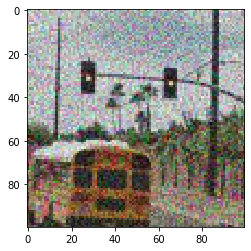

prediction : [[3.3255483e-07 3.3740048e-06 9.2777723e-01 4.0769613e-05 3.4677967e-08
  1.6980706e-05 3.9884819e-07 8.2981906e-09 9.4050485e-18 8.3389284e-07
  3.7351729e-05 1.7873276e-08 7.2122663e-02]]
prediction.shape : (1, 13)
argsort : 2
bus 


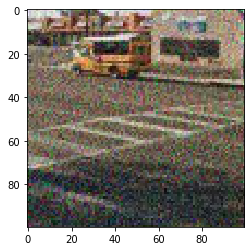

prediction : [[9.5278347e-06 1.4980700e-05 9.2103547e-01 1.8464802e-03 5.0271975e-10
  7.6867305e-02 2.1000544e-05 3.1537459e-07 7.9101425e-14 8.1983919e-05
  1.1204719e-04 1.4230449e-06 9.4051647e-06]]
prediction.shape : (1, 13)
argsort : 2
bus 


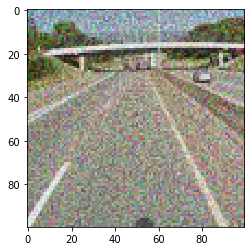

prediction : [[1.7423358e-06 9.8531783e-01 9.1443355e-05 5.2844151e-03 4.9781720e-06
  1.6703516e-06 3.2044733e-07 2.7979834e-07 8.4749181e-06 9.2287557e-03
  1.7416140e-05 4.5952834e-06 3.8160579e-05]]
prediction.shape : (1, 13)
argsort : 1
bridge 


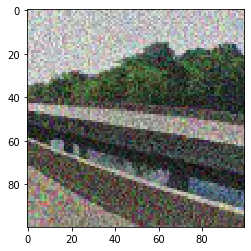

prediction : [[2.6876060e-06 2.8776461e-01 2.7905697e-01 2.2326584e-01 5.4028537e-06
  9.3093215e-05 1.6414315e-06 9.0676383e-07 2.4306826e-07 2.0945406e-01
  2.3946194e-04 2.7472308e-05 8.7643508e-05]]
prediction.shape : (1, 13)
argsort : 1
bridge 


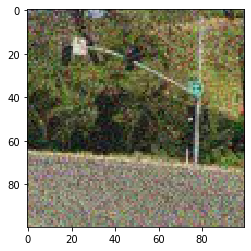

prediction : [[3.8860096e-03 2.0245781e-04 3.0258757e-06 7.6552252e-03 9.2305745e-05
  2.9839159e-03 8.7815395e-05 8.0107107e-05 9.3427934e-03 8.1032306e-01
  1.0294162e-01 4.5901514e-03 5.7811532e-02]]
prediction.shape : (1, 13)
argsort : 9
other 


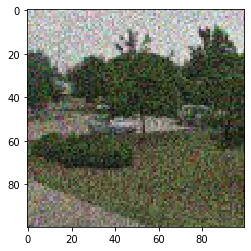

prediction : [[3.7679734e-04 9.2307391e-04 7.8979699e-04 6.4815223e-01 2.7213717e-04
  4.8602168e-03 2.0681207e-05 2.4921985e-04 6.3569270e-05 1.7082739e-01
  1.2812735e-02 1.7411520e-03 1.5891106e-01]]
prediction.shape : (1, 13)
argsort : 3
car 


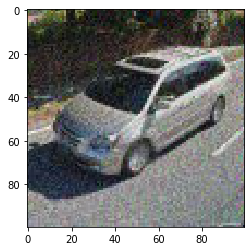

prediction : [[5.54677126e-06 2.96044400e-05 1.01842941e-03 9.98917580e-01
  8.03883626e-11 7.13826375e-06 5.46078411e-07 2.11279917e-06
  1.02910146e-13 1.68474598e-05 1.19757988e-06 6.84760778e-07
  2.26451050e-07]]
prediction.shape : (1, 13)
argsort : 3
car 


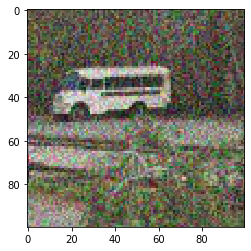

prediction : [[1.04128176e-05 2.41805756e-05 9.97183084e-01 2.29466171e-03
  8.62570193e-09 1.66693921e-04 5.86225087e-06 2.46338232e-07
  3.60597598e-12 1.76099973e-04 1.05426414e-04 2.50395369e-05
  8.30616955e-06]]
prediction.shape : (1, 13)
argsort : 2
bus 


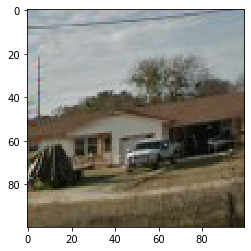

prediction : [[9.6629730e-05 5.1588755e-02 7.4207527e-03 6.2626404e-01 2.6299194e-03
  4.3469260e-04 3.6819054e-06 2.0493837e-05 5.1191204e-05 2.8398862e-01
  1.6743287e-02 3.5809136e-03 7.1769687e-03]]
prediction.shape : (1, 13)
argsort : 3
car 
[[1. 1. 0.]
 [0. 0. 0.]
 [0. 1. 0.]]


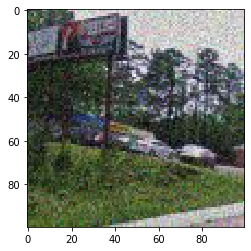

prediction : [[3.4297603e-01 1.7242447e-02 5.2798730e-03 2.6482385e-01 1.9146466e-04
  1.7378269e-03 1.3803747e-04 1.0104956e-01 4.8266479e-06 2.1859689e-01
  2.4537162e-03 2.7019935e-02 1.8485501e-02]]
prediction.shape : (1, 13)
argsort : 0
bicycle 


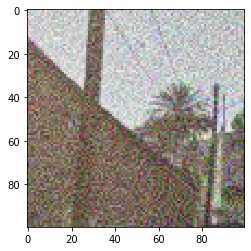

prediction : [[8.5569260e-04 8.5192425e-03 1.4280883e-04 8.4840013e-03 7.6067626e-02
  4.4234167e-03 9.9784615e-05 1.1961451e-04 4.5925111e-04 8.9286220e-01
  3.9798659e-03 1.1374963e-03 2.8489607e-03]]
prediction.shape : (1, 13)
argsort : 9
other 


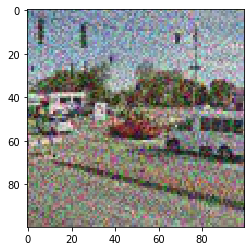

prediction : [[2.3564509e-05 3.5900128e-04 2.8459679e-02 9.5717841e-01 5.0291186e-07
  7.5550177e-03 2.5196903e-07 8.2906423e-05 3.0078429e-12 5.2422889e-05
  1.2024457e-03 2.8393920e-06 5.0828378e-03]]
prediction.shape : (1, 13)
argsort : 3
car 
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Please also check the new images.


KeyboardInterrupt: 

In [17]:
def delay(i = 2):
    time.sleep(random.randint(i,i+1))
    

def clear_directory(dir_path = './'):
    
    for f in os.listdir(dir_path):
        os.remove(os.path.join(dir_path, f))

working_dir = '/Users/benji/Desktop/UTC/GI01/captchas/new_captcha/'
os.chdir(working_dir)

# Create new folder to store images of the new captcha 
current_time = datetime.datetime.now().strftime("%Hh%Mm%S")
new_folder = 'captcha_' + current_time 
if not os.path.exists(new_folder):
    os.makedirs(new_folder)

os.chdir(new_folder)

# Launch Chrome with Selenium
driver = webdriver.Chrome(ChromeDriverManager().install())
delay()

pyautogui.hotkey('command', 'shiftright', 'up') # make it full screen (personal keyboard shortcut)

# Go to reCAPTCHA website
driver.get("https://benji2264.github.io/heli_captcha_solver/index.html")

# Switch to reCAPTCHA frame
frames = driver.find_elements_by_tag_name("iframe")
driver.switch_to.frame(frames[0]);
delay()

# Click on checkbox to activate reCAPTCHA
driver.find_element_by_class_name("recaptcha-checkbox-border").click()
delay()

# Switch to reCAPTCHA challenge frame
driver.switch_to.default_content()
frames = driver.find_elements_by_tag_name("iframe")
driver.switch_to.frame(frames[2]);
delay()

resolve_captchaV1(driver)

# Check the error message
delay(1)
error_msg = driver.find_element_by_xpath("/html/body/div/div/div[2]").text.split('\n')[-1]
print(error_msg)

while (error_msg == 'Please try again.') or (error_msg == 'Please select all matching images.') or (error_msg == 'Please also check the new images.'):
    
    if error_msg == 'Please try again.':
        resolve_captchaV1(driver)
        delay(1)
        error_msg = driver.find_element_by_xpath("/html/body/div/div/div[2]").text.split('\n')[-1]
        print(error_msg)
        
    elif error_msg == 'Please select all matching images.':
        # TODO : choose the most likely image among the new images
        print(error_msg)
        break